### Exploratory Data Analysis of Steam data

In [277]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [278]:
playtime_df = pd.read_csv('../data/steam_playtime.csv')

In [279]:
playtime_df.sort_values(by='playtime_forever', ascending=False).head()

,appid,steam_id,playtime_2weeks,playtime_forever
1390891,10,76561197995417670,19894,5096160
330644,550,76561198152959083,20154,3083602
330659,730,76561198152959083,20154,3007440
330671,218620,76561198152959083,20154,3002293
1293636,730,76561197960828778,0,2999875


In [280]:
len(playtime_df)

2440106

### Domain knowledge based filtering

In [226]:
# drop counterstrike i.e. drop rows where appid is 730, 10 or 240
# playtime_df = playtime_df[~playtime_df['appid'].isin([730, 10, 240])]

# drop user playtimes over x minutes
playtime_df = playtime_df[playtime_df['playtime_forever'] < 10000]

In [221]:
# remove user playtimes under x minutes
playtime_df = playtime_df[playtime_df['playtime_forever'] > 60]

In [201]:
# drop extreme playtime_2weeks values, 5000 in 2 weeks equals 5.9 hours a day
playtime_df = playtime_df[playtime_df['playtime_2weeks'] < 5000]

In [228]:
playtime_df.to_csv('../data/steam_playtime_clean.csv', index=False)

### Z-SCORE

In [203]:
# get mean for playtime_forever
users_mean = playtime_df['playtime_forever'].mean()

In [204]:
# get standard deviation for playtime_forever
users_std = playtime_df['playtime_forever'].std()

In [205]:
print(users_mean, users_std)

1946.0460834854914 8110.466434837565


In [206]:
def get_zscore(value, values):
    """Obtain the z-score of a given value"""
    m = users_mean
    s = users_std
    z_score = (value - m)/s
    return np.abs(z_score)

In [207]:
# compute z-scores for all values
playtime_df['z-score'] = playtime_df['playtime_forever'].apply(lambda x: get_zscore(x, playtime_df['playtime_forever']))

# find outliers
outliers = playtime_df[playtime_df['z-score']>3]
outliers.sort_values(by='playtime_forever', ascending=False)

,appid,steam_id,playtime_2weeks,playtime_forever,z-score
686631,240,76561197985937657,645,129972,15.785276
361532,730,76561198023635244,8,129968,15.784783
1607295,363970,76561198010609680,0,129957,15.783427
1002675,730,76561198185815287,0,129940,15.781331
1245328,730,76561198063474056,0,129923,15.779235
...,...,...,...,...,...
1289265,252530,76561198121110199,0,26283,3.000685
665558,105600,76561198152228567,0,26283,3.000685
975320,730,76561198370454950,0,26280,3.000315
740808,546980,76561198389256257,0,26279,3.000192


In [208]:
# z-score too big around the 131k mark
inliers = playtime_df[playtime_df['z-score']<3]
inliers.sort_values(by='playtime_forever', ascending=False)

,appid,steam_id,playtime_2weeks,playtime_forever,z-score
1285534,33930,76561198132522077,0,26276,2.999822
859249,578080,76561198246341938,0,26276,2.999822
985797,22200,76561198266927056,0,26274,2.999575
758122,240,76561198024069963,0,26274,2.999575
1743222,200510,76561198031146329,0,26273,2.999452
...,...,...,...,...,...
2053799,743090,76561198038405441,0,11,0.238586
1907015,548680,76561197993603269,0,11,0.238586
1516758,355840,76561198089337979,0,11,0.238586
2327055,10680,76561197986837008,0,11,0.238586


In [89]:
inliers['playtime_forever'].mean()

1755.3761528011873

In [90]:
# z-score does not take care of crazy playtime_2weeks values
inliers.sort_values(by=['playtime_2weeks'], ascending=False)

,appid,steam_id,playtime_2weeks,playtime_forever,z-score
988361,1293830,76561198829679996,20122,117365,2.677608
38862,1449850,76561198282319523,20096,124043,2.834966
38820,539720,76561198282319523,20096,102833,2.335181
988354,252490,76561198829679996,20057,117609,2.683357
4368,1172470,76561198892059854,20057,43369,0.933990
...,...,...,...,...,...
806410,386070,76561198014500153,0,20,0.087472
806411,268500,76561198014500153,0,4673,0.022170
806412,427190,76561198014500153,0,624,0.073239
806413,427270,76561198014500153,0,2152,0.037234


In [230]:
inliers.to_csv('../data/steam_playtime_clean.csv', index=False)

### Interquartile Range

In [281]:
# define the lower and upper bound 
q1 = np.quantile(playtime_df['playtime_forever'], 0.25)
q3 = np.quantile(playtime_df['playtime_forever'], 0.75) 
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

# find records that fall outside of the lower and upper bound
iqr_outliers = playtime_df[(playtime_df['playtime_forever']<lower_bound) | (playtime_df['playtime_forever']>upper_bound)]
iqr_outliers.sort_values(by='playtime_forever', ascending=False)

,appid,steam_id,playtime_2weeks,playtime_forever
1390891,10,76561197995417670,19894,5096160
330644,550,76561198152959083,20154,3083602
330659,730,76561198152959083,20154,3007440
330671,218620,76561198152959083,20154,3002293
1293636,730,76561197960828778,0,2999875
...,...,...,...,...
1079503,49520,76561198195312009,0,1620
1502263,457140,76561197961214342,0,1620
1197962,895400,76561198215022868,0,1620
638055,203160,76561198114091987,0,1620


In [282]:
iqr_inliers = playtime_df[(playtime_df['playtime_forever']>lower_bound) & (playtime_df['playtime_forever']<upper_bound)]
iqr_inliers.sort_values(by='playtime_forever', ascending=False)

,appid,steam_id,playtime_2weeks,playtime_forever
1109915,1531540,76561197990048103,0,1618
1375264,291650,76561198017178682,0,1618
2298142,224580,76561198010309180,0,1618
1312684,374040,76561198051468071,0,1618
2405049,107410,76561198019832554,0,1618
...,...,...,...,...
638699,453170,76561198275062480,0,1
253436,219200,76561198014563288,0,1
1360803,24780,76561197965229315,0,1
638698,468700,76561198275062480,0,1


In [283]:
iqr_inliers.sort_values(by=['playtime_2weeks'], ascending=False)

,appid,steam_id,playtime_2weeks,playtime_forever
1134172,1149460,76561198178845671,1617,1617
671479,1446780,76561198074913331,1616,1616
633060,1096530,76561198012214848,1614,1614
1834688,1996040,76561197966826746,1612,1612
1659055,1488200,76561198002604499,1608,1608
...,...,...,...,...
810396,584210,76561198007054511,0,149
810395,582500,76561198007054511,0,5
810393,568570,76561198007054511,0,1185
810392,8500,76561198007054511,0,189


In [94]:
iqr_inliers.to_csv('../data/steam_playtime_clean.csv', index=False)

### EXPLORATION & PLOTS

/home/berry/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='playtime_forever'>

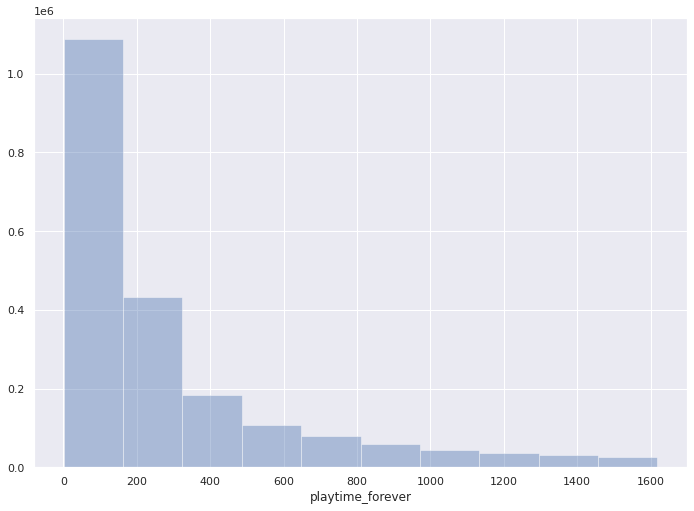

In [284]:
# plot distribution of playtime_forever
sns.distplot(iqr_inliers['playtime_forever'], kde=False, bins=10)

In [189]:
sort_by_2weeks = playtime_df.sort_values(by='playtime_2weeks', ascending=False)

In [190]:
sort_by_2weeks

,appid,steam_id,playtime_2weeks,playtime_forever
1862309,578080,76561197960437463,4992,55049
653989,271590,76561198143213523,4985,14525
310923,1506830,76561198323712048,4985,14928
1265021,604540,76561198095257393,4976,4976
1088385,1325200,76561197995840552,4968,6662
...,...,...,...,...
819304,10190,76561198076482862,0,1096
819302,32370,76561198076482862,0,17
819301,17470,76561198076482862,0,84
819298,240,76561198076482862,0,4874


In [191]:
# sort by playtime_forever
sort_by_playtime = playtime_df.sort_values(by = ['playtime_forever'], ascending = False).reset_index()

In [192]:
sort_by_playtime

,index,appid,steam_id,playtime_2weeks,playtime_forever
0,686631,240,76561197985937657,645,129972
1,361532,730,76561198023635244,8,129968
2,1607295,363970,76561198010609680,0,129957
3,1002675,730,76561198185815287,0,129940
4,1245328,730,76561198063474056,0,129923
...,...,...,...,...,...
2143584,366091,1151640,76561197966665386,0,11
2143585,1836386,70600,76561197980891330,0,11
2143586,2363325,357480,76561197991856426,0,11
2143587,2329090,241540,76561198035823175,0,11


<AxesSubplot:>

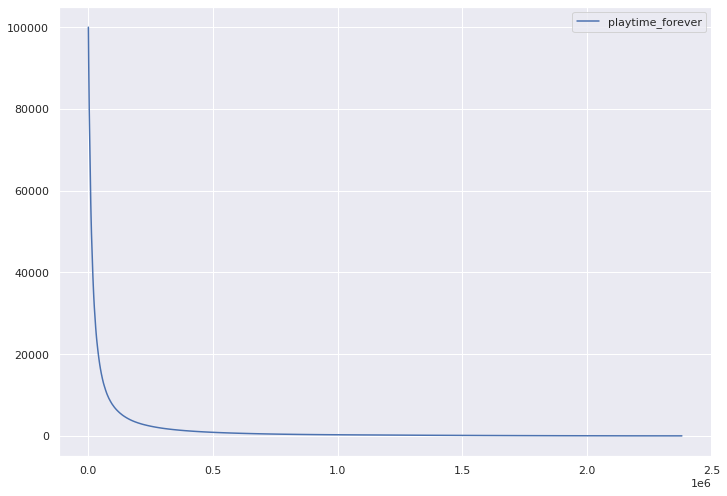

In [119]:
sort_by_playtime.plot(y='playtime_forever', use_index=True)

<AxesSubplot:xlabel='playtime_forever', ylabel='Count'>

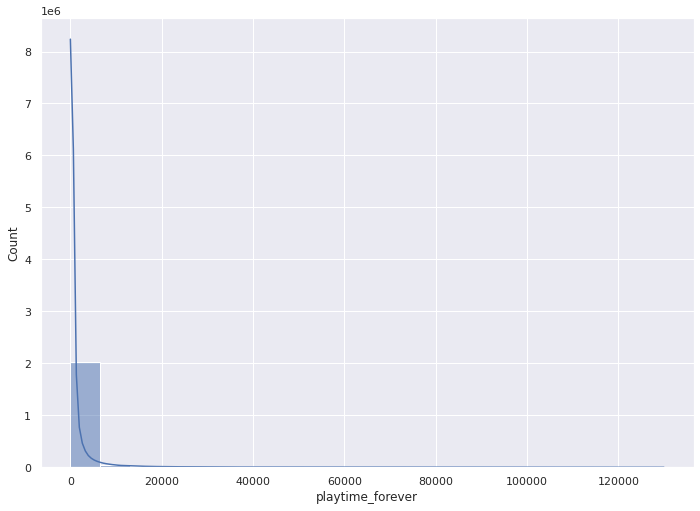

In [193]:
# plot sort_by_playtime
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(sort_by_playtime['playtime_forever'], bins = 20, kde = True)


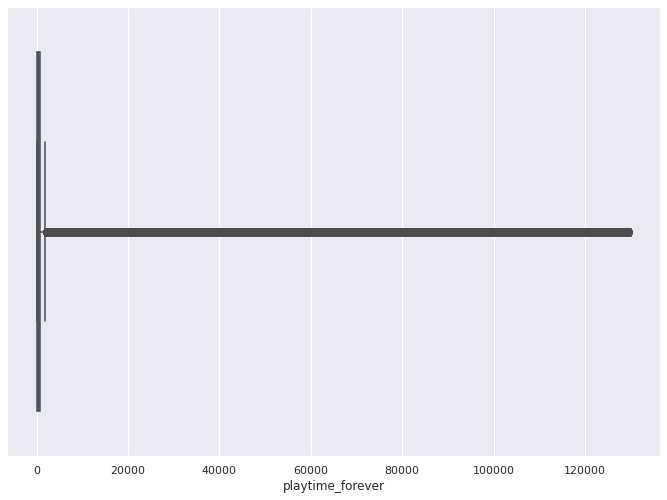

In [194]:
sns.boxplot(x=sort_by_playtime['playtime_forever'])
plt.show()

In [210]:
# group by appid and get count, mean, median, min, max
playtime_by_game = playtime_df.groupby('appid').agg({'playtime_forever': ['count', 'mean', 'median', 'min', 'max']}).round(2)

In [211]:
# sort by mean
playtime_by_game.sort_values(by=('playtime_forever', 'mean'), ascending=False)

playtime_forever                                
                   count     mean   median    min    max
appid                                                   
699860                 1  94896.0  94896.0  94896  94896
620630                 1  94895.0  94895.0  94895  94895
44680                  1  92628.0  92628.0  92628  92628
649670                 1  89311.0  89311.0  89311  89311
1536420                1  67275.0  67275.0  67275  67275
...                  ...      ...      ...    ...    ...
761160                 1     11.0     11.0     11     11
953370                 1     11.0     11.0     11     11
406690                 1     11.0     11.0     11     11
1249300                1     11.0     11.0     11     11
923470                 1     11.0     11.0     11     11

[24685 rows x 5 columns]

In [212]:
# sort by count
playtime_by_game.sort_values(by=('playtime_forever', 'count'), ascending=True).head(30)

playtime_forever                        
                   count   mean median  min  max
appid                                           
1243520                1   24.0   24.0   24   24
725120                 1   69.0   69.0   69   69
725170                 1  443.0  443.0  443  443
374717                 1   15.0   15.0   15   15
725330                 1  139.0  139.0  139  139
257260                 1   15.0   15.0   15   15
1224480                1   61.0   61.0   61   61
482670                 1   41.0   41.0   41   41
374723                 1   13.0   13.0   13   13
374726                 1   11.0   11.0   11   11
987000                 1   41.0   41.0   41   41
725510                 1  258.0  258.0  258  258
374727                 1   48.0   48.0   48   48
725720                 1   33.0   33.0   33   33
374730                 1   14.0   14.0   14   14
1223810                1  990.0  990.0  990  990
725980                 1   41.0   41.0   41   41
1222750                1  613.0  613.0  613  613
1222600                1  184.0  184.0  184  184
1222400                1  379.0  379.0  379  379
1222340                1  325.0  325.0  325  325
726120                 1   12.0   12.0   12   12
726160                 1  215.0  215.0  215  215
1222290                1   19.0   19.0   19   19
479200                 1   37.0   37.0   37   37
1222210                1   49.0   49.0   49   49
479170                 1  178.0  178.0  178  178
726200                 1   33.0   33.0   33   33
479000                 1   30.0   30.0   30   30
726230                 1  326.0  326.0  326  326

In [213]:
# playtime_by_game where count is 1
playtime_by_game[playtime_by_game[('playtime_forever', 'count')] == 1]

playtime_forever                        
                   count   mean median  min  max
appid                                           
1525                   1   23.0   23.0   23   23
2680                   1   11.0   11.0   11   11
2930                   1   20.0   20.0   20   20
3150                   1   31.0   31.0   31   31
3420                   1   12.0   12.0   12   12
...                  ...    ...    ...  ...  ...
2143950                1   63.0   63.0   63   63
2144560                1   27.0   27.0   27   27
2176130                1  408.0  408.0  408  408
2179630                1   45.0   45.0   45   45
2216360                1   67.0   67.0   67   67

[4178 rows x 5 columns]

Text(0.5, 0, 'Game')

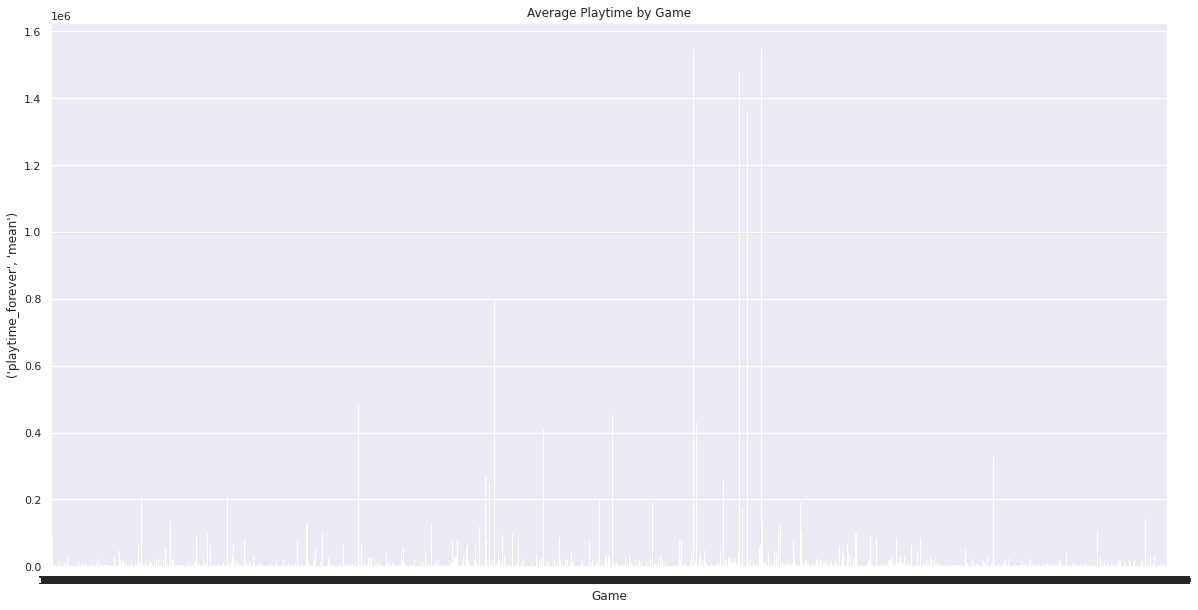

In [56]:
# plot playtime by game
plt.figure(figsize=(20,10))
sns.barplot(x=playtime_by_game.index, y = playtime_by_game[('playtime_forever', 'mean')])
plt.title('Average Playtime by Game')
plt.xlabel('Game')


<AxesSubplot:ylabel='Frequency'>

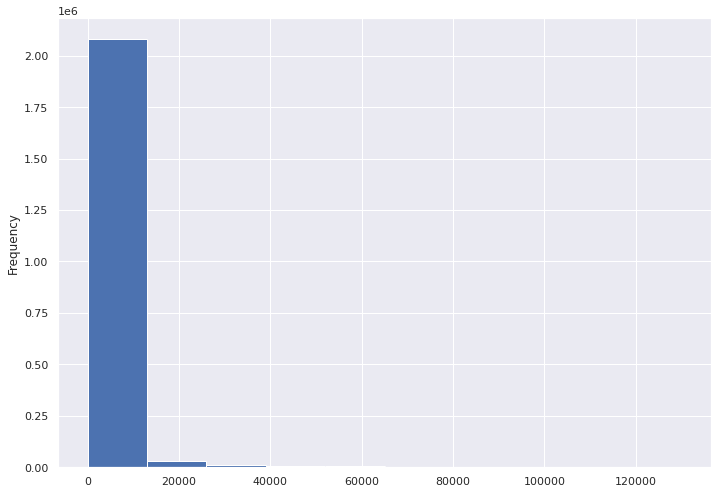

In [167]:
# plot distribution of playtimes
sortplaytime = playtime_df['playtime_forever'].sort_values(ascending = False)
sortplaytime.plot(kind = 'hist')

In [ ]:
sns.histplot(sortplaytime)
plt.show()

<AxesSubplot:>

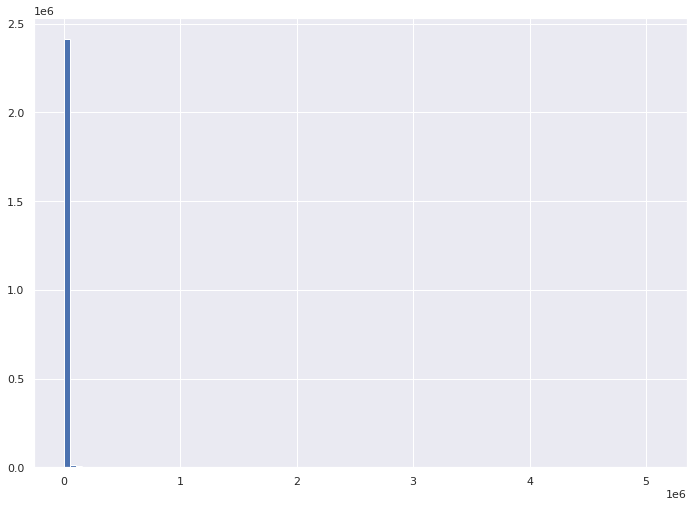

In [308]:
# show bins of playtime forever
playtime_df['playtime_forever'].hist(bins=100)

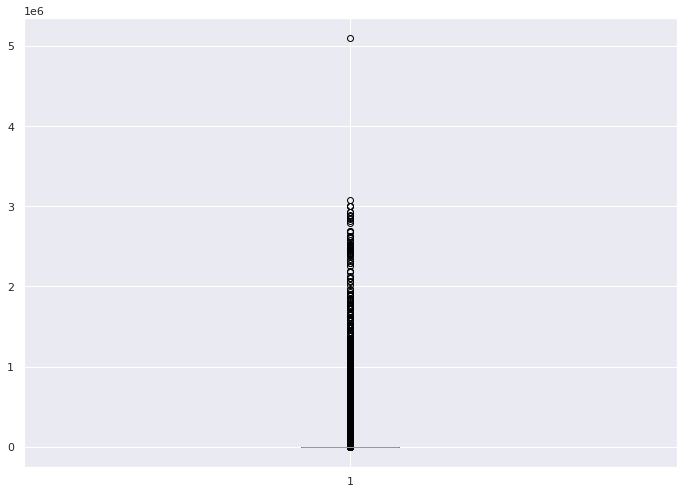

In [309]:
# plot boxplot
plt.boxplot(playtime_df['playtime_forever'])
plt.show()

In [214]:
# get appids where count is 1
only_one_playtime = playtime_by_game[playtime_by_game[('playtime_forever', 'count')] == 1].index

In [216]:
# exclude games with only one playtime
playtime_df = playtime_df[~playtime_df['appid'].isin(only_one_playtime)]

In [217]:
playtime_df

,appid,steam_id,playtime_2weeks,playtime_forever,z-score
0,240,76561198015529005,0,315,0.201104
1,300,76561198015529005,0,90,0.228846
3,340,76561198015529005,0,45,0.234394
4,10180,76561198015529005,0,1406,0.066586
5,10190,76561198015529005,0,17051,1.862403
...,...,...,...,...,...
2440100,1517290,76561198071594531,0,1744,0.024912
2440101,1522820,76561198071594531,0,636,0.161525
2440102,1248130,76561198071594531,0,5867,0.483444
2440104,1252330,76561198071594531,0,90,0.228846


### GAME METADATA

In [296]:
games_df = pd.read_csv('../data/steam_app_metadata.csv')

In [297]:
games_df

,appid,name,description,developer,publisher,categories,genres
0,240,Counter-Strike: Source,THE NEXT INSTALLMENT OF THE WORLD'S # 1 ONLINE...,Valve,Valve,"['Multi-player', 'Cross-Platform Multiplayer',...",['Action']
1,300,Day of Defeat: Source,Day of Defeat offers intense online action gam...,Valve,Valve,"['Multi-player', 'Cross-Platform Multiplayer',...",['Action']
2,320,Half-Life 2: Deathmatch,Fast multiplayer action set in the Half-Life 2...,Valve,Valve,"['Multi-player', 'Valve Anti-Cheat enabled', '...",['Action']
3,340,Half-Life 2: Lost Coast,Originally planned as a section of the Highway...,Valve,Valve,"['Single-player', 'Commentary available', 'Rem...",['Action']
4,10180,Call of Duty®: Modern Warfare® 2,The most-anticipated game of the year and the ...,Infinity Ward,Activision,"['Single-player', 'Multi-player', 'Co-op', 'St...",['Action']
...,...,...,...,...,...,...,...
25510,1715980,Bail or Jail(OBAKEIDORO!),"<img src=""https://cdn.akamai.steamstatic.com/s...","FREE STYLE, Inc.",Konami Digital Entertainment,"['Single-player', 'Multi-player', 'PvP', 'Onli...","['Action', 'Casual', 'Sports']"
25511,1785000,Mokoko X,"<h2 class=""bb_tag"">About</h2>Mokoko X was insp...",NAISU,NAISU,"['Single-player', 'Steam Achievements', 'Full ...","['Action', 'Casual', 'Indie']"
25512,1846920,Lust Academy - Season 1,"<img src=""https://cdn.akamai.steamstatic.com/s...",Bear in the Night,Bear in the Night,"['Single-player', 'Steam Achievements', 'Steam...","['Adventure', 'Casual', 'Indie']"
25513,611300,Task Force,<h1>Workshop Support</h1><p>Task Force provide...,Tracer Interactive,Tracer Interactive,"['Multi-player', 'PvP', 'Online PvP', 'Co-op',...","['Action', 'Indie', 'Strategy', 'Early Access']"


In [298]:
len(games_df)

25515

In [306]:
# count nulls for each column
games_df.isnull().sum()

appid            0
name             0
description     54
developer        2
publisher      294
categories       0
genres           0
dtype: int64

In [301]:
useless_games = games_df[(games_df['developer'] == 'None') & games_df['publisher'].isnull()]

In [302]:
useless_games.isnull().sum()

appid            0
name             1
description    798
developer        0
publisher      850
categories       0
genres           0
dtype: int64

In [303]:
games_df = games_df[~games_df['appid'].isin(useless_games['appid'])]

In [305]:
games_df[games_df['description'].isnull()]

,appid,name,description,developer,publisher,categories,genres
2135,1249200,Ghostrunner Demo,NaN,One More Level,All in! Games,"['Single-player', 'Game demo', 'Steam Achievem...",['Action']
3311,94500,Back to the Future: Ep 2 - Get Tannen!,NaN,Telltale Games,Telltale Games,[],[]
3312,94510,Back to the Future: Ep 3 - Citizen Brown,NaN,Telltale Games,Telltale Games,[],[]
3313,94520,Back to the Future: Ep 4 - Double Visions,NaN,Telltale Games,Telltale Games,[],[]
3314,94530,Back to the Future: Ep 5 - OUTATIME,NaN,Telltale Games,Telltale Games,[],[]
3940,400430,The Vanishing of Ethan Carter Redux,NaN,The Astronauts,NaN,"['Single-player', 'Downloadable Content', 'Ste...","['Adventure', 'Indie']"
4227,107430,ARMA X: Anniversary Edition,NaN,Bohemia Interactive,Bohemia Interactive,[],[]
5217,807920,Onii-Chan,NaN,voksolril,voksolril,"['Single-player', 'Steam Achievements']",[]
7668,347360,The Making of Grim Fandango Remastered: E3 and...,NaN,Double Fine Productions,NaN,"['Full controller support', 'Native Steam Cont...",[]
7669,347370,The Making of Grim Fandango Remastered: The Re...,NaN,Double Fine Productions,NaN,"['Full controller support', 'Native Steam Cont...",[]


In [307]:
games_df[games_df['developer'] == 'None']

,appid,name,description,developer,publisher,categories,genres
3297,253920,Gorky 17,November 2008. NATO intelligence services repo...,None,Topware Interactive ACE,"['Single-player', 'Steam Trading Cards']","['RPG', 'Strategy']"
3317,419220,3 Suicides of Paul Hamilton,<h1>Steam Video</h1><p>This content is only av...,None,Devolver Digital Films,"['Full controller support', 'Native Steam Cont...",[]
3321,253940,Septerra Core,"At the very heart of Septerra lies the Core, a...",None,Topware Interactive,"['Single-player', 'Steam Trading Cards', 'Stea...",['RPG']
3322,396160,Secret Of Magia,Secret of Magia is an action RPG.<br />\r\n<br...,None,Senpai Studios,"['Single-player', 'Steam Achievements', 'Full ...","['Action', 'Adventure', 'Indie', 'RPG']"
3325,254100,World War II: Panzer Claws,<strong>WORLD WAR II: PANZER CLAWS [aka Frontl...,None,Topware Interactive,"['Single-player', 'Multi-player', 'PvP', 'Onli...",['Strategy']
...,...,...,...,...,...,...,...
21994,518440,K-On! The Movie,<h1>Steam Video</h1><p>This content is only av...,None,Sentai Filmworks,"['Full controller support', 'Native Steam Cont...",[]
21995,518450,K-On! The Movie: K-On! The Movie (Japanese),"With graduation right around the corner, every...",None,Sentai Filmworks,"['Full controller support', 'Native Steam Cont...",[]
22822,382740,The Poisoning,<h1>Steam Video</h1><p>This content is only av...,None,Devolver Digital Films,"['Full controller support', 'Native Steam Cont...",[]
22896,750070,Motorbike Garage Mechanic Simulator,"<h1>⚔️ 20% OFF ⚔️ NEW RELEASE ⚔️ Good Night, ...",None,No Gravity Games,"['Single-player', 'Steam Achievements']","['Indie', 'Racing', 'Simulation']"


In [289]:
games_df[games_df['developer'].isnull()]

,appid,name,description,developer,publisher,categories,genres
25152,38040,Jo Jo's Fashion Show 2,NaN,NaN,NaN,[],[]
25330,39350,Nertz Solitaire,NaN,NaN,NaN,[],[]
